<img src='app/static/img/logo.png' style="display: block; margin: auto;" width='120'>

# Table of Contents
* [Import Libraries](#import-libraries)
* [Connect to Database](#connect-to-database)
* [Load Data](#load-data)
* [Pivot Table](#pivot-table)
* [Save Feature Names Order](#save-feature-names-order)
* [Pulling Label from Video table and merging it](#pulling-label-from-video-table-and-merging-it)
* [Create Time Series Tensor](#create-time-series-tensor)
* [Seperate Feature Matrix and Label Vector](#separate-feature-matrix-and-label-vector)
* [Label Encoder + One-Hot Encoder](#label-encoder--one-hot)
* [Scaling](#scaling)
* [Split Data into Train and Test Sets](#split-data-into-train-and-test-sets)
* [Configure Tensorboard](#configure-tensorboard)
* [Build LSTM Model](#build-lstm-model)
  * [Compile Model](#compile-model)
  * [Set Callbacks](#set-callbacks)
  * [Start Tensorboard](#start-tensorboard)
  * [Train Model](#train-model)
  * [Training History](#training-history)
* [Evaluate](#evaluate-model)
  * [Accuracy](#accuracy)
  * [Classification Report](#classification-report)
  * [Confusion Matrix](#confusion-matrix)
* [t-SNE](#t-sne)
  * [Create Intermediate Layer for t-SNE](#create-intermediate-layer-for-t-sne)
  * [Get Intermediate Layer Output](#get-intermediate-layer-output)
  * [Reduction to 2D Space with t-SNE](#reduction-to-2d-space-with-t-sne)
  * [Visualize t-SNE](#visualize-t-sne)
* [Save the Model, LabelEncoder and Scaler](#save-the-model-labelencoder-and-scaler)

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
)

2025-05-12 14:23:53.978273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 14:23:53.998883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747049034.013453  321660 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747049034.017293  321660 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 14:23:54.037680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Connect to Database

In [2]:
engine = create_engine('sqlite:///app/sign-language-recognition.sqlite')

# Load Data

In [3]:
df = pd.read_sql('SELECT * FROM video_feature', engine)

In [4]:
df.head()

,id,video_id,feature_name,value,start_frame,end_frame
0,774721,1,left_tips_x_mean,0.486560,1,7
1,774722,1,left_tips_x_std,0.420042,1,7
2,774723,1,left_tips_y_mean,0.641197,1,7
3,774724,1,left_tips_y_std,0.289314,1,7
4,774725,1,left_tips_z_mean,-0.044394,1,7


# Pivot Table

Her pencere (start_frame, video_id) için tüm feature_name → value’ları pivot yapıyoruz.

In [5]:
pivot = df.pivot_table(
    index=["video_id", "start_frame", "end_frame"],
    columns="feature_name",
    values="value",
).reset_index()

In [6]:
pivot.head()

feature_name,video_id,start_frame,end_frame,joints_x_mean,joints_x_std,joints_y_mean,joints_y_std,joints_z_mean,joints_z_std,left_tips_x_mean,...,left_tips_y_mean,left_tips_y_std,left_tips_z_mean,left_tips_z_std,right_tips_x_mean,right_tips_x_std,right_tips_y_mean,right_tips_y_std,right_tips_z_mean,right_tips_z_std
0,1,1,7,0.501609,0.311639,0.769098,0.126312,-0.388854,0.346394,0.486560,...,0.641197,0.289314,-0.044394,0.020514,0.673981,0.331375,0.787907,0.153233,0.032333,0.119376
1,1,8,14,0.512939,0.219529,0.680079,0.163863,-0.424323,0.374454,0.723231,...,0.119657,0.079117,-0.011089,0.029442,0.539203,0.091240,0.875373,0.020643,-0.058394,0.042221
2,1,15,21,0.518004,0.157802,0.664708,0.183265,-0.325135,0.298613,0.639712,...,0.071650,0.052390,0.065106,0.038930,0.683871,0.030990,0.899406,0.018319,0.025076,0.037063
3,1,22,28,0.523399,0.149180,0.693894,0.193820,-0.300252,0.272926,0.677613,...,0.696846,0.358881,0.054322,0.038271,0.662566,0.021753,0.300056,0.353334,0.050873,0.044929
4,1,29,35,0.522667,0.147916,0.690223,0.192829,-0.290415,0.263737,0.661286,...,0.358390,0.391244,0.044475,0.044613,0.674605,0.028804,0.625804,0.383294,0.045570,0.040439


# Save Feature Names Order

for later use prediction

In [7]:
feature_columns = pivot.columns.drop(['video_id', 'start_frame', 'end_frame']).tolist()

with open("app/model/feature_order.json", "w") as f:
    json.dump(feature_columns, f)

# Pulling Label from Video table and merging it

In [8]:
videos = pd.read_sql('SELECT id, label FROM video', engine)
data = pivot.merge(videos, left_on='video_id', right_on='id')

In [9]:
data.head()

,video_id,start_frame,end_frame,joints_x_mean,joints_x_std,joints_y_mean,joints_y_std,joints_z_mean,joints_z_std,left_tips_x_mean,...,left_tips_z_mean,left_tips_z_std,right_tips_x_mean,right_tips_x_std,right_tips_y_mean,right_tips_y_std,right_tips_z_mean,right_tips_z_std,id,label
0,1,1,7,0.501609,0.311639,0.769098,0.126312,-0.388854,0.346394,0.486560,...,-0.044394,0.020514,0.673981,0.331375,0.787907,0.153233,0.032333,0.119376,1,afternoon
1,1,8,14,0.512939,0.219529,0.680079,0.163863,-0.424323,0.374454,0.723231,...,-0.011089,0.029442,0.539203,0.091240,0.875373,0.020643,-0.058394,0.042221,1,afternoon
2,1,15,21,0.518004,0.157802,0.664708,0.183265,-0.325135,0.298613,0.639712,...,0.065106,0.038930,0.683871,0.030990,0.899406,0.018319,0.025076,0.037063,1,afternoon
3,1,22,28,0.523399,0.149180,0.693894,0.193820,-0.300252,0.272926,0.677613,...,0.054322,0.038271,0.662566,0.021753,0.300056,0.353334,0.050873,0.044929,1,afternoon
4,1,29,35,0.522667,0.147916,0.690223,0.192829,-0.290415,0.263737,0.661286,...,0.044475,0.044613,0.674605,0.028804,0.625804,0.383294,0.045570,0.040439,1,afternoon


# Create Time Series Tensor

In [10]:
sequence_length = 5  # Kaç ardışık pencere bir örnek oluşturacak?

samples = []
labels = []

for vid, group in data.groupby("video_id"):
    group = group.sort_values("start_frame")
    
    # Etiketleri aynı kalacak şekilde sadece özellikleri al
    feats = group.drop(columns=['video_id','start_frame','end_frame','id','label']).values
    lbls = group['label'].values

    # Kaydırmalı pencere üret
    for i in range(len(feats) - sequence_length + 1):
        window = feats[i:i+sequence_length]
        label = lbls[i + sequence_length - 1]  # son pencerenin etiketi
        samples.append(window)
        labels.append(label)

# Separate feature matrix and label vector

In [11]:
X = np.array(samples, dtype=np.float32)
y_raw = np.array(labels)

# Label encoder + one-hot

In [12]:
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
y = to_categorical(y_int)

In [13]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (18446, 5, 18)
y.shape: (18446, 11)


# Scaling

In [14]:
scaler = StandardScaler()
X_reshaped = X.reshape(X.shape[0] * X.shape[1], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape[0], X.shape[1], -1)

# Split Data into Train and Test Sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (14756, 5, 18) (14756, 11)
Test set: (3690, 5, 18) (3690, 11)


# Configure Tensorboard

In [16]:
log_dir = "log/" + tf.timestamp().numpy().astype(str)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Clear any logs from previous runs
# !rm -rf ./log/

I0000 00:00:1747049106.809773  321660 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2152 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Build LSTM Model

In [17]:
input_timesteps = X_train.shape[1]     # sequence length (örnek: 5)
input_features = X_train.shape[2]      # feature sayısı (örnek: 18 veya daha fazla)
num_classes = y_train.shape[1]         # sınıf sayısı (örnek: 11)

In [18]:
input_layer = Input(shape=(input_timesteps, input_features))
x = LSTM(128, return_sequences=True, name="lstm_1")(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = LSTM(64, name="lstm_2")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model

In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,315 (509.04 KB)

 Trainable params: 129,931 (507.54 KB)

 Non-trainable params: 384 (1.50 KB)

# Set Callbacks

In [21]:
callbacks = [
    ModelCheckpoint(
        filepath='app/model/sign_language_recognition.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    EarlyStopping(patience=10, restore_best_weights=True),
    tensorboard
]

# Start Tensorboard

In [23]:
%load_ext tensorboard
%tensorboard --logdir=log/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 321968), started 0:00:02 ago. (Use '!kill 321968' to kill it.)

# Train Model

In [24]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/150


I0000 00:00:1747049164.631259  321914 cuda_dnn.cc:529] Loaded cuDNN version 90300


365/369 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6286 - loss: 1.1818
Epoch 1: val_loss improved from inf to 0.22306, saving model to app/model/sign_language_recognition.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6305 - loss: 1.1758 - val_accuracy: 0.9262 - val_loss: 0.2231 - learning_rate: 0.0010
Epoch 2/150
364/369 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8893 - loss: 0.3335
Epoch 2: val_loss improved from 0.22306 to 0.14672, saving model to app/model/sign_language_recognition.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8895 - loss: 0.3330 - val_accuracy: 0.9468 - val_loss: 0.1467 - learning_rate: 0.0010
Epoch 3/150
362/369 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9244 - loss: 0.2429
Epoch 3: val_loss improved from 0.14672 to 0.11422, saving model to app/model/sign_language_recognition.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9244 - loss: 0.2427 - val_accuracy: 0.9560 - val_loss: 0.1142 - learning_rate: 0.0010
Ep

# Training History

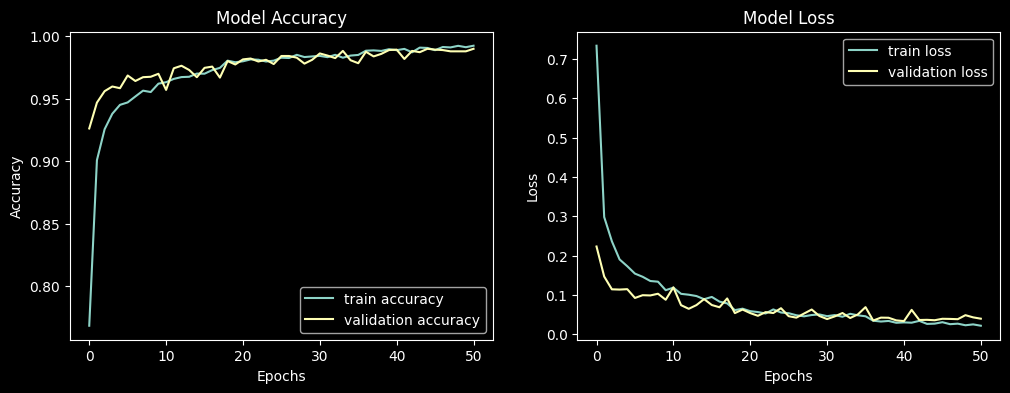

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model

## Accuracy

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0536
Test Accuracy: 0.9867, Test Loss: 0.0459


## Classification Report

In [27]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

   afternoon       0.99      1.00      0.99       266
         age       0.98      0.99      0.99       387
         boy       1.00      1.00      1.00       290
     country       0.98      0.95      0.96       428
         day       0.99      1.00      0.99       427
      monday       1.00      1.00      1.00       212
        name       0.99      0.98      0.98       401
       night       1.00      1.00      1.00       322
      people       1.00      1.00      1.00       422
      person       1.00      1.00      1.00       238
        time       0.93      0.96      0.95       297

    accuracy                           0.99      3690
   macro avg       0.99      0.99      0.99      3690
weighted avg       0.99      0.99      0.99      3690



## Confusion Matrix

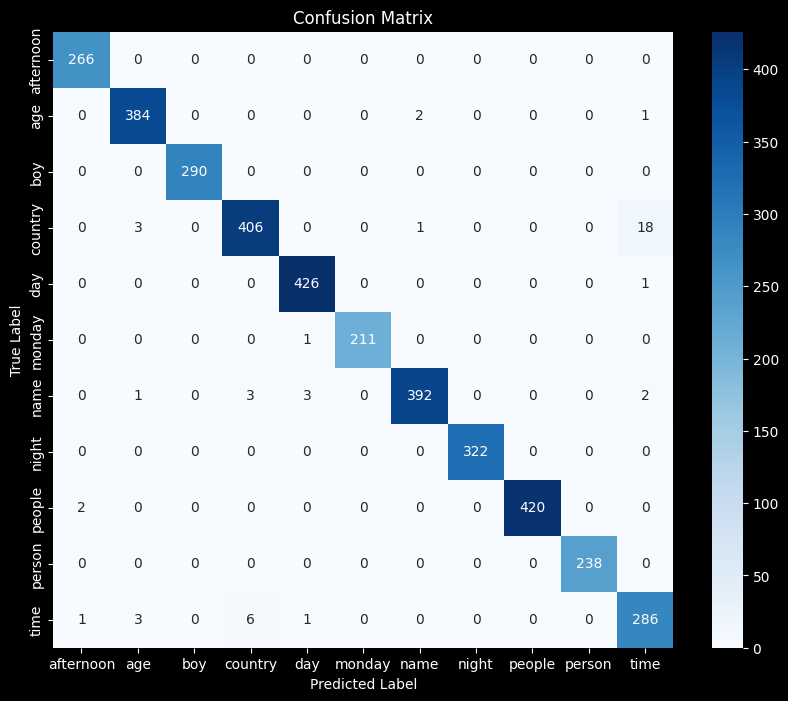

In [28]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# t-SNE
## Create Intermediate Layer for t-SNE

In [ ]:
intermediate_layer_model = Model(
    inputs=model.input, outputs=model.get_layer("lstm_2").output
)

## Get Intermediate Layer Output

In [30]:
X_train_lstm = intermediate_layer_model.predict(X_train)
X_test_lstm = intermediate_layer_model.predict(X_test)

462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


## Reduction to 2D Space with t-SNE

In [31]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_test_lstm)

## Visualize t-SNE

In [32]:
# One-hot vektörü -> sınıf etiketine dönüştür
y_test_int = np.argmax(y_test, axis=1)
labels = le.inverse_transform(y_test_int)

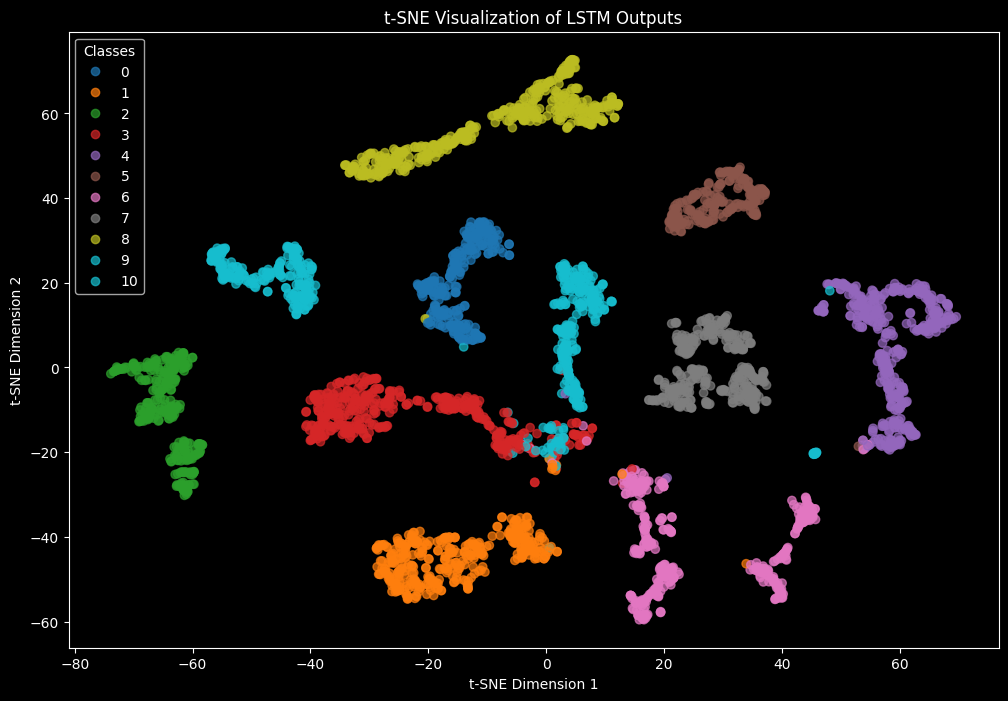

In [33]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_int, cmap='tab10', alpha=0.7)
plt.title('t-SNE Visualization of LSTM Outputs')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(False)
plt.legend(*scatter.legend_elements(), title="Classes", loc="best")
plt.show()

# Save the Model, LabelEncoder and Scaler

for later use prediction

In [34]:
model.save('app/model/sign_language_recognition.keras')
joblib.dump(le, "app/model/label_encoder.pkl")
joblib.dump(scaler, "app/model/scaler.pkl")

['app/model/scaler.pkl']